### Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
#import campnew data as dataframe
campnew=pd.read_csv('..\clean_data\campnew.csv')
campnew['date']=pd.to_datetime(campnew['date'], format='%d/%m/%Y')
print("date range is: ", campnew.date.min(), campnew.date.max())

date range is:  2018-09-17 00:00:00 2018-10-04 00:00:00


In [4]:
campnew=campnew.set_index('date')

### EDA

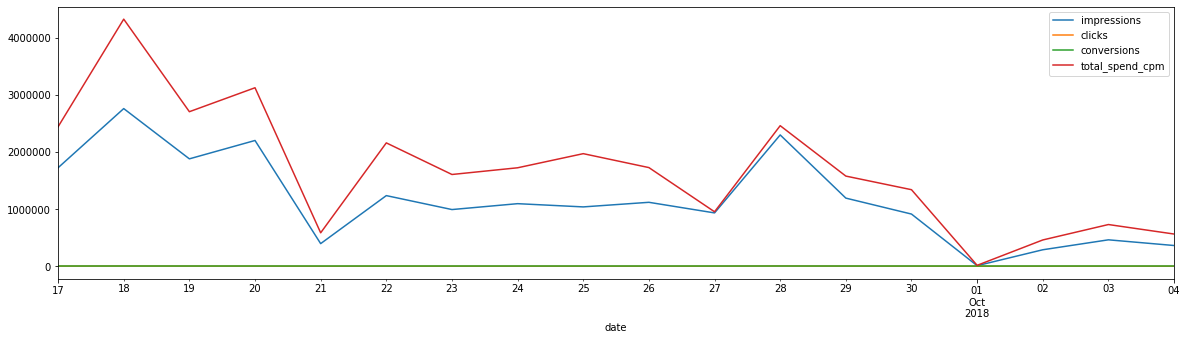

In [73]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(312)#
#ax3 = fig.add_subplot(313)

campnew.groupby(campnew.index)['impressions'].sum().plot(kind='line', ax=ax1, figsize=(20,5), legend = True)
campnew.groupby(campnew.index)['clicks'].sum().plot(kind='line', ax=ax1, figsize=(20,5), legend = True)
campnew.groupby(campnew.index)['conversions'].sum().plot(kind='line',ax=ax1, figsize=(20,5), legend = True)
campnew.groupby(campnew.index)['total_spend_cpm'].sum().plot(kind='line', ax=ax1, figsize=(20,5), legend = True)

In [77]:
campnew.columns

Index(['Unnamed: 0', 'business_vertical_x', 'country_x', 'region', 'city_code',
       'strategy_id', 'channel_name_x', 'goal_type', 'total_spend_cpm',
       'impressions', 'clicks', 'conversions', 'business_vertical_y',
       'channel_name_y', 'country_y'],
      dtype='object')

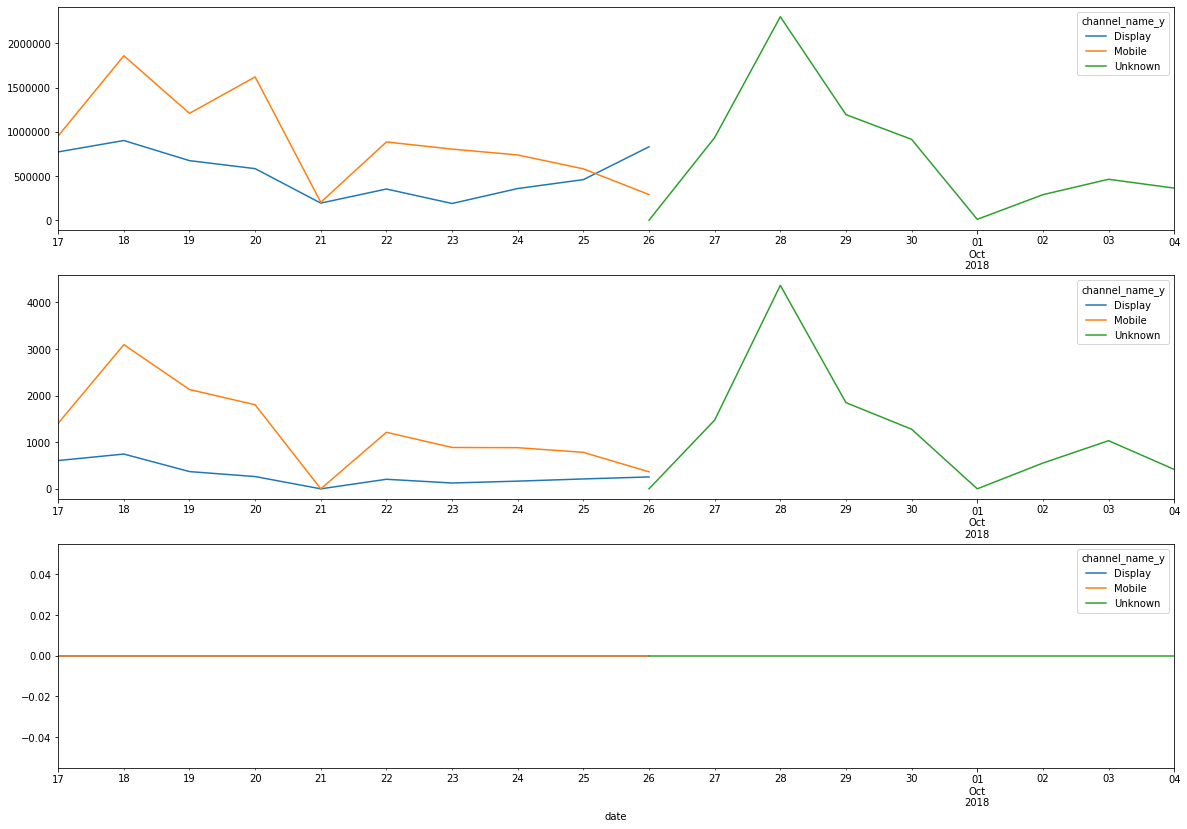

In [10]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.2)

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

campnew.groupby([campnew.index,'channel_name_y'])['impressions'].sum().unstack().plot(kind='line', ax=ax1, figsize=(20,14), legend = True)
campnew.groupby([campnew.index,'channel_name_y'])['clicks'].sum().unstack().plot(kind='line', ax=ax2, figsize=(20,14), legend = True)
campnew.groupby([campnew.index,'channel_name_y'])['conversions'].sum().unstack().plot(kind='line',ax=ax3, figsize=(20,14), legend = True)
#campnew.groupby([campnew.index,'channel_name_y'])['total_spend_cpm'].sum().unstack().plot(kind='line', ax=ax1, figsize=(20,5), legend = True)

#### <font color=red>Observation: </font>
#### As the value of conversions is always 0, there is no meaning to use a model to predict. Simply guess the future conversions is also 0.
#### From 17Sep2018 to 26Sep2018, impressions and clicks use display and mobile channels. While from 26Sep2018 to 04Oct2018, the channel becomes unknown (data missing). Therefore, we will analyze based on the data from 17Sep2018 to 25Sep2018.

### Decompose Impressions

In [5]:
#select dataframe with display channel and timeseries before 26Sep2018
campnew=campnew[(campnew['channel_name_y']=='Display') & (campnew.index <='2018-09-25')]

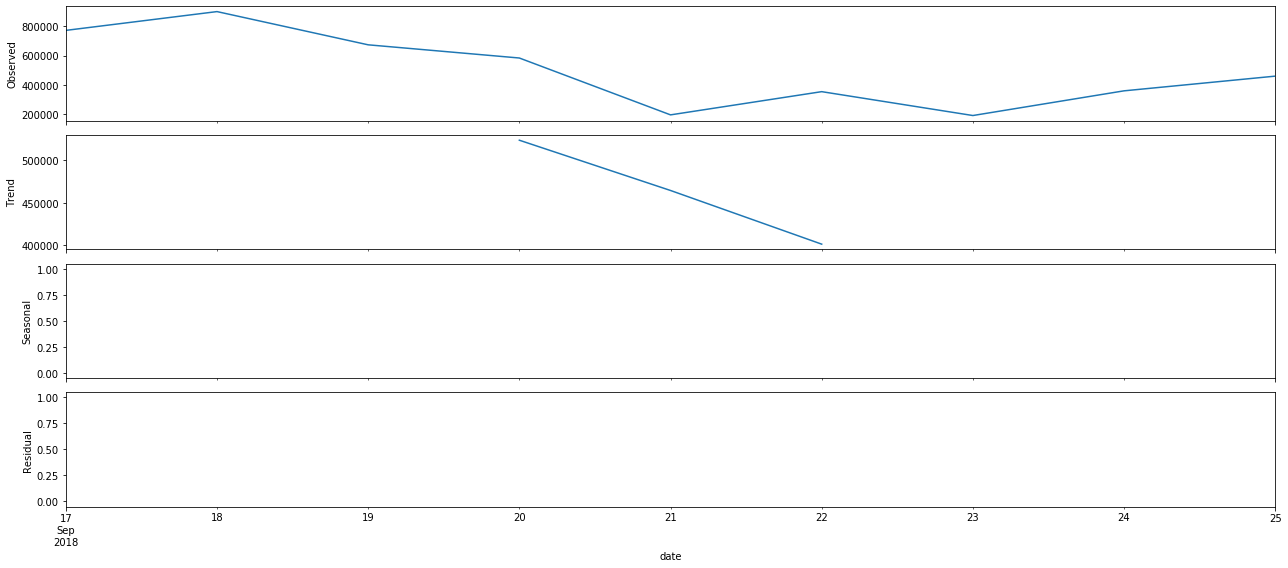

In [5]:
#decompose time series into three distinct components: trend, seasonality, and noise
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(campnew.groupby(campnew.index)['impressions'].sum(), model='additive')
fig = decomposition.plot()
plt.show()

#### <font color=red>Observation: </font>
####   From the decomposed charts, impressions' trend is decreaing among 20-22Sep2018, and have NO seasonality behavior.

### Decompose Clicks

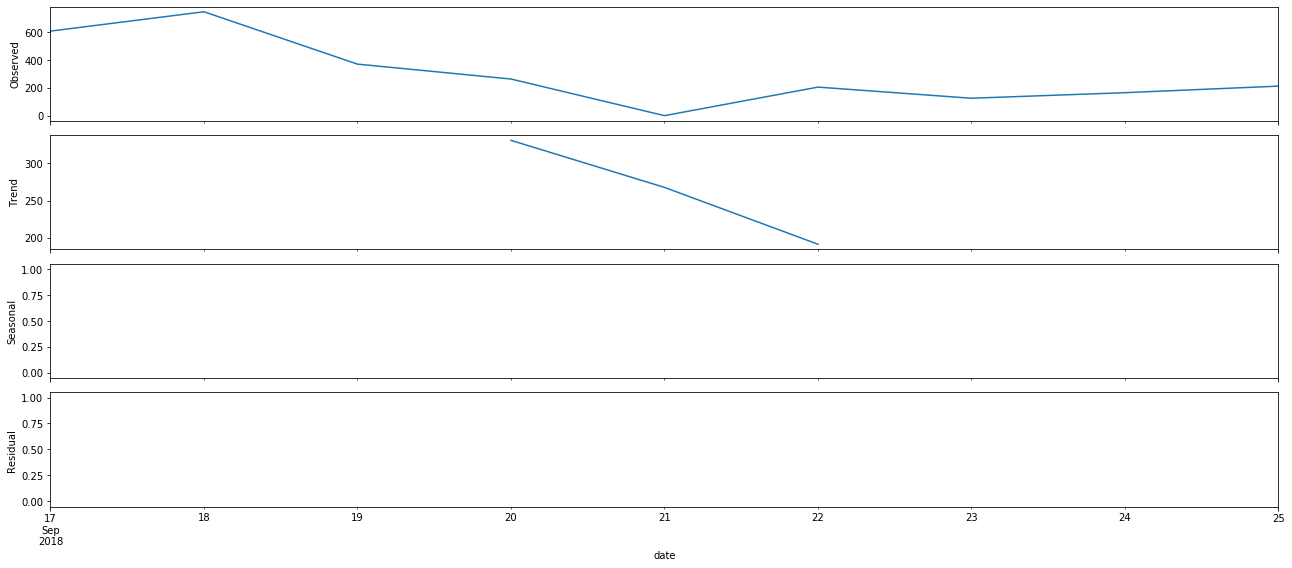

In [6]:
#decompose time series into three distinct components: trend, seasonality, and noise
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(campnew.groupby(campnew.index)['clicks'].sum(), model='additive')
fig = decomposition.plot()
plt.show()

#### <font color=red>Observation: </font>
####   From the decomposed charts, clicks' trend is decreaing among 20-22Sep2018, and have NO seasonality behavior.

### Decompose Conversions

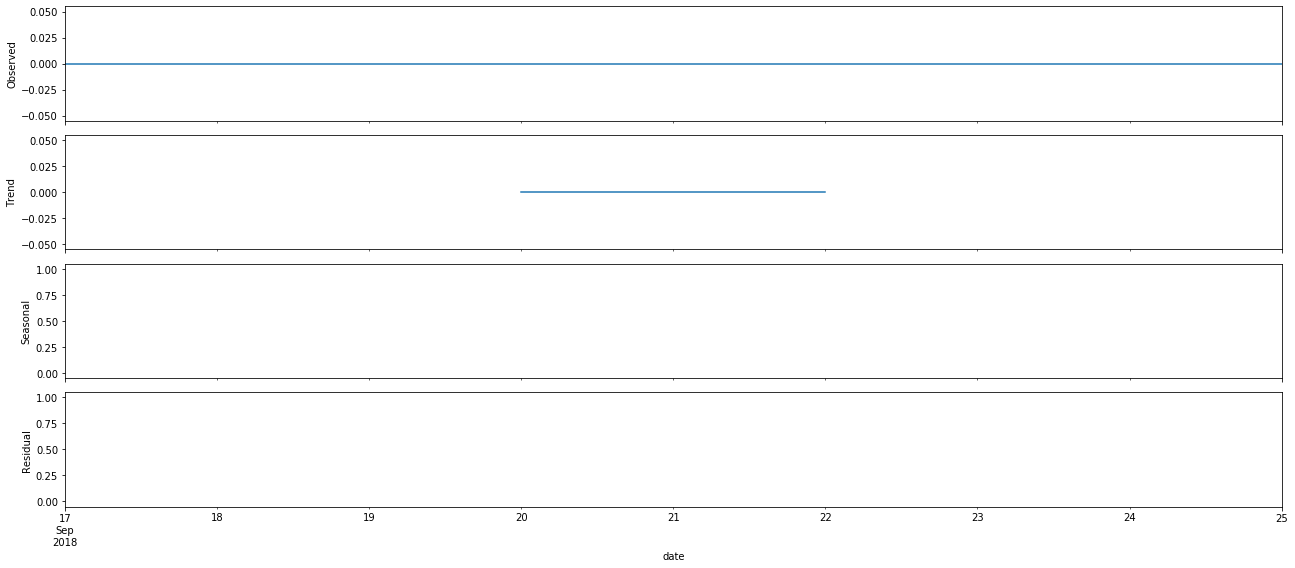

In [7]:
#decompose time series into three distinct components: trend, seasonality, and noise
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(campnew.groupby(campnew.index)['conversions'].sum(), model='additive')
fig = decomposition.plot()
plt.show()

#### <font color=red>Observation: </font>
####   From the decomposed charts, conversions are always 0, conversions' trend has no change among 20-22Sep2018, and have NO seasonality behavior.

### ARIMA

#### From previous observation, we first differentiate the time series of impressions to make it more stationary, this helps determine the **d value** in ARIMA(p,d,q) model

In [6]:
#select impressions data series
series = campnew['impressions']
series.head()

date
2018-09-17     88.0
2018-09-17     48.0
2018-09-17    157.0
2018-09-17    124.0
2018-09-17    415.0
Name: impressions, dtype: float64

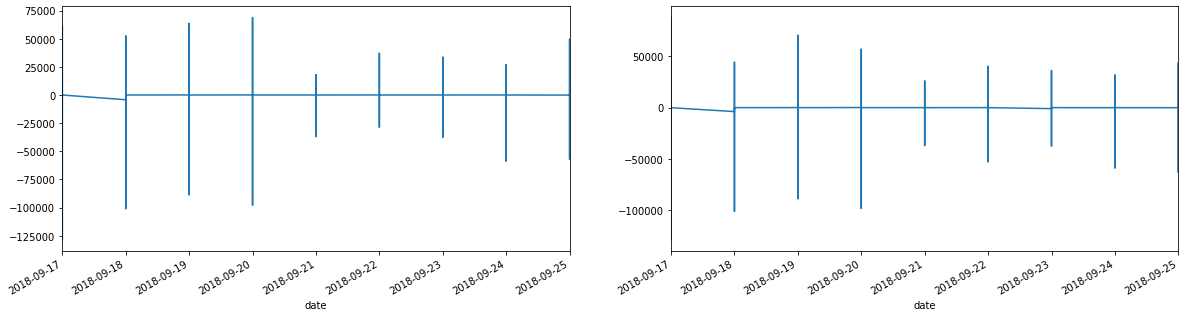

In [9]:
#try differentiating using 1 and 2
def parser(x):
	return dt.datetime.strptime(x, '%d/%m/%Y')
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
diff1 = series.diff(1)
diff1.plot(ax=ax1)
diff2 = series.diff(2)
diff2.plot(ax=ax2)

#### <font color=red>Observation: </font>
#### We will use 1 as value of d in model ARIMA(p,d,q) since 1 and 2 doesn't show much difference from the chart

### We need to determine p and q value, which will determine model selection
#### First, check the ACF and PACF with lags 100 and 20 

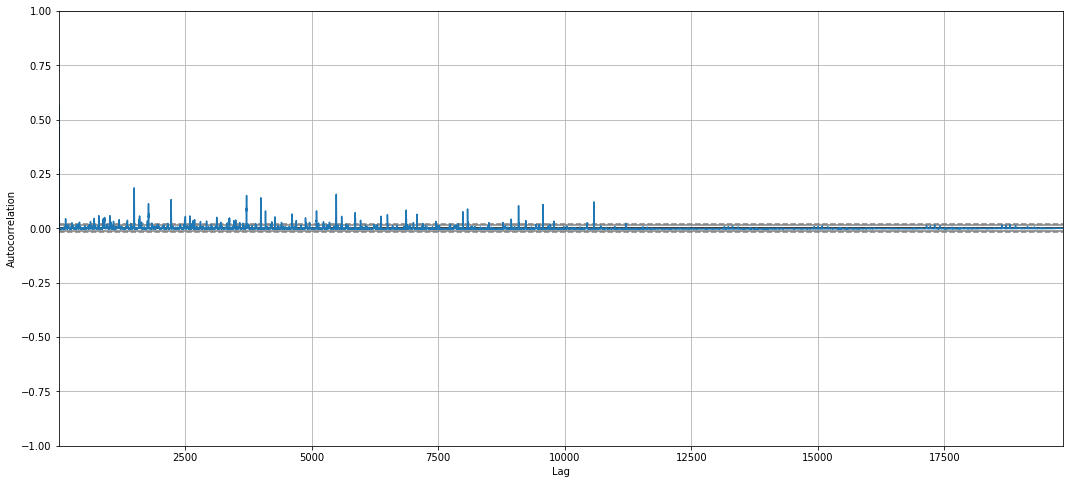

In [10]:
#autocorrelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

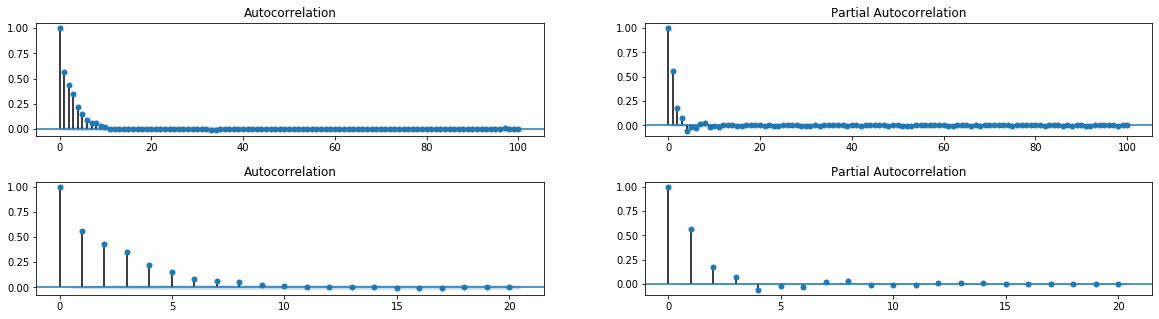

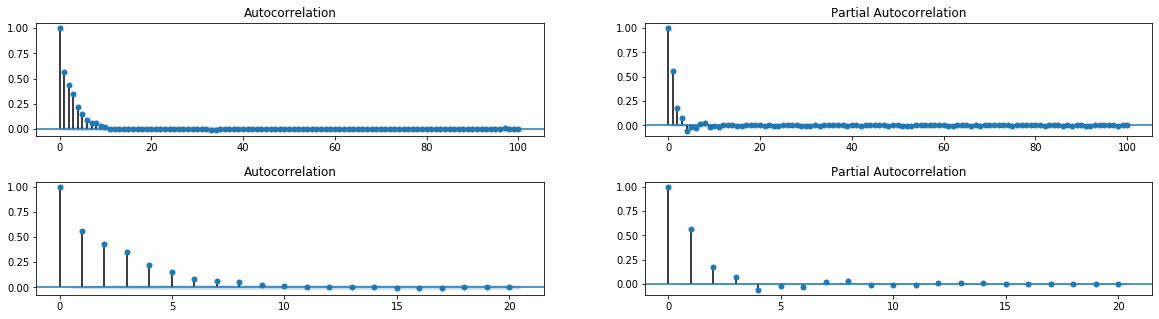

In [11]:
#acf & pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(20,5))
plt.subplots_adjust(hspace=0.4)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plot_acf(series,lags=100,ax=ax1)
plot_pacf(series, lags=100, ax=ax2)
plot_acf(series,lags=20,ax=ax3)
plot_pacf(series, lags=20, ax=ax4)

#### <font color=red>Observation: </font>
#### From ACF, the autocorrelations are significant for lag 6. After lag 6, the autocorrelation becomes 0. ---> MA(q)
#### From PACF, the partial autocorrelation is significant at lag 2. ---> AR(p)
#### Therefore, we will testing by using AR variable p=4, MA variable q=6.

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c

                             ARIMA Model Results                              
Dep. Variable:          D.impressions   No. Observations:                19848
Model:                 ARIMA(4, 1, 6)   Log Likelihood             -178339.477
Method:                       css-mle   S.D. of innovations           1931.617
Date:                Mon, 16 Sep 2019   AIC                         356702.955
Time:                        10:15:50   BIC                         356797.705
Sample:                             1   HQIC                        356733.966
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0283      0.007     -4.351      0.000      -0.041      -0.016
ar.L1.D.impressions     0.5643        nan        nan        nan         nan         nan
ar.L2.D.impressi

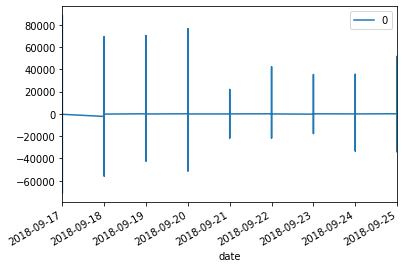

The density plot of the residual error values:


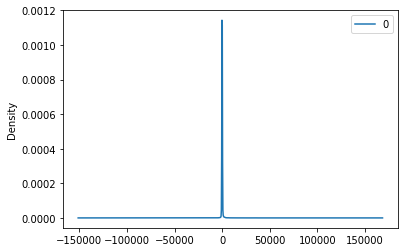

Below shows the distribution of the residual errors. The mean value shows there is a bias in the prediction:
                  0
count  19848.000000
mean      -9.716115
std     1933.167133
min   -71339.506034
25%     -132.311879
50%      -65.000813
75%       -7.790053
max    88482.900638


In [7]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(series, order=(4,1,6))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
print("The residual errors show that there may still be some trend information not captured by the model:")
residuals.plot()
plt.show()
print("The density plot of the residual error values:")
residuals.plot(kind='kde')
plt.show()
print("Below shows the distribution of the residual errors. The mean value shows there is a bias in the prediction:")
print(residuals.describe())

#### <font color=red>Observation: </font>
#### The residual errors seem fine with zero mean and uniform variance

In [15]:
from sklearn.metrics import mean_squared_error
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size],  X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(4,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=11.987573, expected=0.000000
predicted=2.052464, expected=1.000000
predicted=5.341926, expected=17.000000
predicted=9.678272, expected=27.000000
predicted=19.483903, expected=5.000000
predicted=10.828198, expected=34.000000
predicted=24.043945, expected=17.000000
predicted=18.731098, expected=12.000000
predicted=17.581792, expected=0.000000
predicted=5.431566, expected=0.000000
predicted=4.795815, expected=1.000000
predicted=2.070179, expected=5.000000
predicted=4.049322, expected=2.000000
predicted=2.277802, expected=2.000000
predicted=2.249841, expected=4.000000
predicted=3.016416, expected=0.000000
predicted=1.551428, expected=49.000000
predicted=28.071166, expected=2.000000
predicted=11.361882, expected=32.000000
predicted=25.798260, expected=1.000000
predicted=7.465369, expected=41.000000
predicted=32.120196, expected=3.000000
predicted=10.446757, expected=0.000000
predicted=9.483850, expected=1.000000
predicted=1.112794, expected=1.000000
predicted=4.405264, expected=6.

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.075570, expected=31.000000
predicted=20.038935, expected=15.000000
predicted=15.153738, expected=4.000000
predicted=11.197969, expected=9.000000
predicted=8.151238, expected=0.000000
predicted=5.202514, expected=4.000000
predicted=4.881050, expected=16.000000
predicted=10.094563, expected=8.000000
predicted=9.128221, expected=12.000000
predicted=10.679060, expected=3.000000
predicted=5.676029, expected=6.000000
predicted=7.146814, expected=1.000000
predicted=2.944546, expected=36.000000
predicted=22.215402, expected=10.000000
predicted=13.386559, expected=12.000000
predicted=14.562631, expected=1.000000
predicted=4.606611, expected=17.000000
predicted=14.650490, expected=74.000000
predicted=45.783690, expected=12.000000
predicted=25.466343, expected=3.000000
predicted=15.113765, expected=2.000000
predicted=5.067535, expected=1.000000
predicted=8.000422, expected=1.000000
predicted=2.117086, expected=3.000000
predicted=2.282370, expected=1.000000
predicted=1.488844, expected

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=28.274252, expected=3.000000
predicted=12.548475, expected=1.000000
predicted=6.474164, expected=33.000000
predicted=23.496872, expected=12.000000
predicted=14.861405, expected=35.000000
predicted=27.086679, expected=1.000000
predicted=9.628318, expected=31.000000
predicted=25.570920, expected=2.000000
predicted=8.727362, expected=15.000000
predicted=16.437452, expected=3.000000
predicted=5.157637, expected=0.000000
predicted=5.573785, expected=0.000000
predicted=0.621507, expected=2.000000
predicted=2.442013, expected=25.000000
predicted=14.602719, expected=3.000000
predicted=7.096428, expected=6.000000
predicted=7.627555, expected=25.000000
predicted=15.800672, expected=33.000000
predicted=26.637070, expected=1.000000
predicted=11.281406, expected=7.000000
predicted=9.505706, expected=10.000000
predicted=9.406811, expected=15.000000
predicted=14.375950, expected=9.000000
predicted=9.656161, expected=2.000000
predicted=5.792467, expected=4.000000
predicted=4.857326, expected

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.439373, expected=0.000000
predicted=1.711234, expected=7.000000
predicted=4.808898, expected=36.000000
predicted=21.586440, expected=45.000000
predicted=33.684184, expected=3.000000
predicted=16.215558, expected=1.000000
predicted=8.436340, expected=0.000000
predicted=3.883688, expected=14.000000
predicted=11.950358, expected=2.000000
predicted=4.250828, expected=1.000000
predicted=3.104711, expected=0.000000
predicted=0.501239, expected=2.000000
predicted=2.499156, expected=0.000000
predicted=0.578851, expected=0.000000
predicted=0.371569, expected=2.000000
predicted=1.105163, expected=10.000000
predicted=6.152196, expected=19.000000
predicted=12.930334, expected=1.000000
predicted=5.925795, expected=0.000000
predicted=3.175168, expected=6.000000
predicted=4.388458, expected=0.000000
predicted=2.915719, expected=3.000000
predicted=2.631983, expected=0.000000
predicted=0.611059, expected=1.000000
predicted=1.521380, expected=2.000000
predicted=1.311774, expected=0.000000
pr

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1.237975, expected=1.000000
predicted=13.271428, expected=3.000000
predicted=2.108359, expected=0.000000
predicted=0.932746, expected=16.000000
predicted=9.449391, expected=569.000000
predicted=320.776493, expected=1.000000
predicted=119.907087, expected=48.000000
predicted=110.975140, expected=15.000000
predicted=20.309831, expected=1.000000
predicted=61.100909, expected=4.000000
predicted=4.776241, expected=1.000000
predicted=5.782549, expected=14.000000
predicted=9.926225, expected=1.000000
predicted=3.661529, expected=49.000000
predicted=29.952508, expected=16.000000
predicted=19.218821, expected=2.000000
predicted=12.863034, expected=6.000000
predicted=6.245615, expected=1.000000
predicted=6.429965, expected=1.000000
predicted=3.059042, expected=0.000000
predicted=0.527195, expected=2.000000
predicted=1.787209, expected=2.000000
predicted=1.607124, expected=120.000000
predicted=67.726302, expected=1.000000
predicted=25.464571, expected=23.000000
predicted=30.918543, expe

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=58.471059, expected=29.000000
predicted=26.731718, expected=1.000000
predicted=10.356302, expected=4.000000
predicted=11.151971, expected=1.000000
predicted=2.874899, expected=122.000000
predicted=71.407203, expected=180.000000
predicted=125.660369, expected=2.000000
predicted=56.395122, expected=1.000000
predicted=27.739798, expected=3.000000
predicted=13.149051, expected=1.000000
predicted=17.256426, expected=1.000000
predicted=1.375595, expected=1.000000
predicted=0.993786, expected=0.000000
predicted=0.611146, expected=1.000000
predicted=0.786674, expected=1.000000
predicted=0.844191, expected=12.000000
predicted=7.126517, expected=9.000000
predicted=7.622013, expected=1.000000
predicted=4.256605, expected=1.000000
predicted=2.183628, expected=1.000000
predicted=1.973969, expected=0.000000
predicted=1.142546, expected=1.000000
predicted=0.786674, expected=3.000000
predicted=1.959777, expected=2.000000
predicted=1.958870, expected=79.000000
predicted=44.911318, expected=22

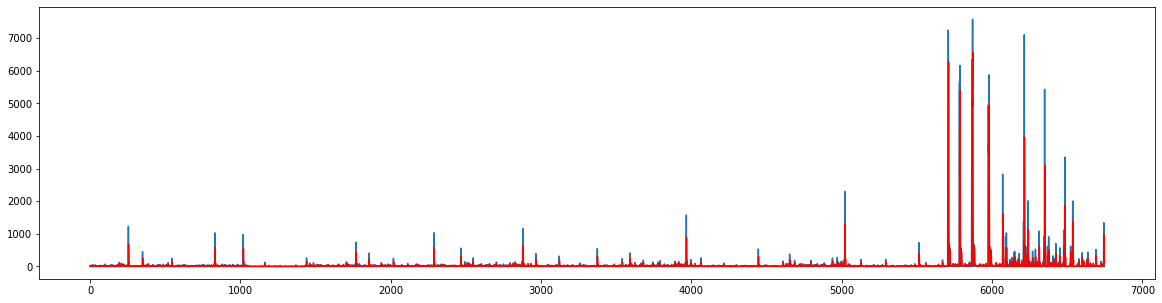

In [16]:
#plot
fig = plt.figure(figsize=(20,5))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

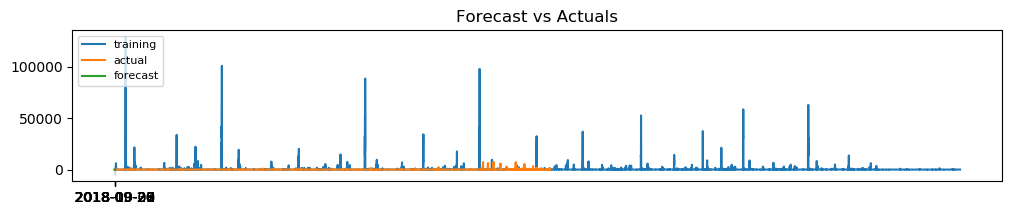

In [9]:
# forecast 7 days
fc, se, conf = model_fit.forecast(7, alpha=0.05)

# make as pandas series
fc_series = pd.Series(fc, index=('2018-09-26','2018-09-27','2018-09-28','2018-09-29','2018-09-30','2018-10-01','2018-10-02'))
lower_series = pd.Series(conf[:, 0], index=('2018-09-26','2018-09-27','2018-09-28','2018-09-29','2018-09-30','2018-10-01','2018-10-02'))
upper_series = pd.Series(conf[:, 1], index=('2018-09-26','2018-09-27','2018-09-28','2018-09-29','2018-09-30','2018-10-01','2018-10-02'))

# plot
plt.figure(figsize=(12,2), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(fc_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

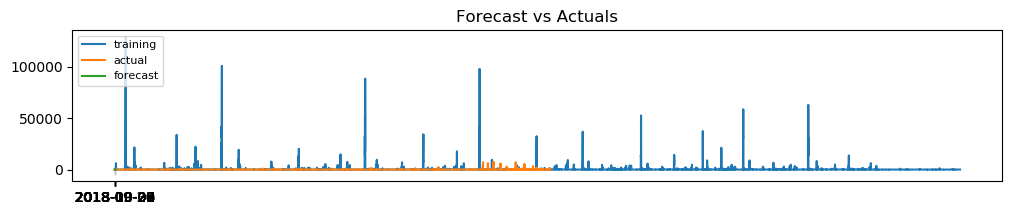

In [11]:
# forecast 14 days
fc, se, conf = model_fit.forecast(14, alpha=0.05)

# make as pandas series
fc_series = pd.Series(fc, 
                      index=('2018-09-26','2018-09-27','2018-09-28','2018-09-29','2018-09-30','2018-10-01','2018-10-02',
                             '2018-10-03','2018-10-04','2018-10-05','2018-10-06','2018-10-07','2018-10-08','2018-10-09'))
lower_series = pd.Series(conf[:, 0], 
                         index=('2018-09-26','2018-09-27','2018-09-28','2018-09-29','2018-09-30','2018-10-01','2018-10-02',
                             '2018-10-03','2018-10-04','2018-10-05','2018-10-06','2018-10-07','2018-10-08','2018-10-09'))
upper_series = pd.Series(conf[:, 1], 
                         index=('2018-09-26','2018-09-27','2018-09-28','2018-09-29','2018-09-30','2018-10-01','2018-10-02',
                             '2018-10-03','2018-10-04','2018-10-05','2018-10-06','2018-10-07','2018-10-08','2018-10-09'))

# plot
plt.figure(figsize=(12,2), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(fc_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [12]:
#the impressions for Display channel at 2018-10-02 is -43.852396, at 2018-10-09 is -57.017579
fc_series

2018-09-26   -59.572501
2018-09-27   -11.221328
2018-09-28     2.125909
2018-09-29   -26.901917
2018-09-30   -58.436155
2018-10-01   -59.436806
2018-10-02   -43.852396
2018-10-03   -41.451798
2018-10-04   -53.603554
2018-10-05   -61.283525
2018-10-06   -56.877207
2018-10-07   -50.803637
2018-10-08   -52.093063
2018-10-09   -57.017579
dtype: float64